# Quantile Regression Toy Models

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
dir_datasets = Path('../../soil/datasets/')
pth_wise3_data = dir_datasets/'ISRIC_WISE/orgc_stock_ISRIC_WISE_clip.csv'

In [ ]:
wise3 = pd.read_csv(pth_wise3_data)
wise3.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
vars_X = ['LATDD', 'LONDD']
var_Y = 'orgc_stock_mineral'

In [ ]:
wise3[vars_X + [var_Y]].head()

,LATDD,LONDD,orgc_stock_mineral
0,41.06944,19.99556,12.11205
1,40.21500,20.64722,6.79968
2,40.34528,19.48361,15.78198
3,41.37778,19.77028,17.50674
4,40.65528,20.95889,7.55993


In [ ]:
X = wise3[vars_X].values
Y = wise3[var_Y].values

In [ ]:
# Y_scaled = preprocessing.scale(Y)
X_scaled = pd.DataFrame(preprocessing.scale(X), columns=vars_X)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=5)

## Helpers

In [ ]:
def correctPcnt(df):
    correct = 0
    obs = df.shape[0]
    for i in range(obs):
        if df.loc[i,0.01] <= df.loc[i,'actual'] <= df.loc[i,0.99]:
            correct += 1
    print(correct/obs)
    
    

def showIntervals(ax, df):
    x = np.arange(len(df))
    y50 = df[0.5].values
    y95 = df[0.95].values
    y05 = df[0.05].values
    
    ax.scatter(x, y50, marker='.')
    ax.fill_between(x, y05, y95, color='red', alpha=0.1)
    return ax

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(
    n_estimators=200, random_state=0, min_samples_split=20)

In [ ]:
%%time

rf.fit(X_train, Y_train)

CPU times: user 396 ms, sys: 8.67 ms, total: 405 ms
Wall time: 431 ms


RandomForestRegressor(min_samples_split=20, n_estimators=200, random_state=0)

In [ ]:
%%time 

# Get the predictions of all trees for all observations
# Each observation has N predictions from the N trees

pred_Q = pd.DataFrame()
for pred in rf.estimators_:
    temp = pd.Series(pred.predict(X_test))#.round(2))
    pred_Q = pd.concat([pred_Q,temp],axis=1)
    
pred_Q.columns = range(len(rf.estimators_))
pred_Q.columns.name = 'tree'
pred_Q.index.name = 'sample'
pred_Q.head()

CPU times: user 525 ms, sys: 42.3 ms, total: 567 ms
Wall time: 650 ms


tree,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
sample,,,,,,,,,,,,,,,,,,,,,
0,15.956258,24.644092,13.979056,24.127283,17.095099,13.508756,14.832630,15.497670,22.459750,15.595326,...,17.586784,15.317572,19.873644,15.296443,16.448525,13.400374,30.076100,14.350118,14.621090,12.572215
1,12.214553,16.398341,10.902211,15.743885,13.117909,10.906615,11.878885,11.727437,18.444524,13.461772,...,17.806181,12.712643,11.473017,8.682470,15.187785,13.592109,11.187688,10.872231,12.631457,11.579479
2,18.577691,9.090967,8.751400,11.324932,15.500847,9.100156,7.738221,8.030645,7.957899,8.707591,...,22.398863,21.190635,15.048507,8.119400,8.431457,8.924891,10.321862,9.229448,10.829841,12.731263
3,9.408968,15.493031,10.261901,5.765315,10.118176,7.603638,15.347331,9.378681,14.034660,19.297163,...,4.403134,13.733603,9.203998,15.556800,8.431457,20.368192,10.321862,18.602527,5.229265,9.926824
4,7.543050,7.695859,3.008222,4.408096,4.850700,5.840176,7.547152,8.430203,4.636586,4.598065,...,5.709000,4.071197,7.680896,5.551459,8.343100,15.851378,4.351053,12.498314,5.602484,3.642186


In [ ]:
quantiles = [0.01, 0.05, 0.50, 0.95 , 0.99]

R2 score is 0.1532692863651801
0.7804054054054054


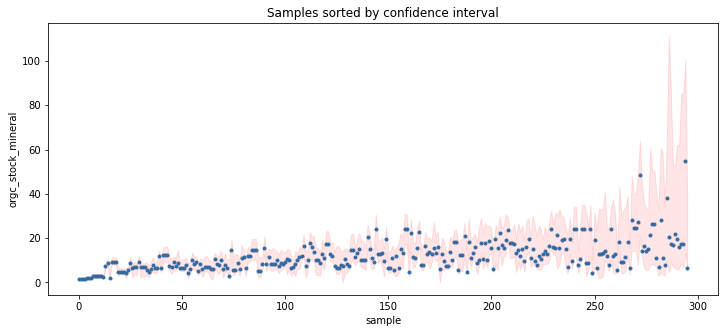

In [ ]:
RF_actual_pred = pd.DataFrame()

for q in quantiles:
    s = pred_Q.quantile(q=q, axis=1)
    RF_actual_pred = pd.concat([RF_actual_pred,s],axis=1,sort=False)

RF_actual_pred.columns = quantiles
RF_actual_pred['actual'] = Y_test
RF_actual_pred['interval'] = RF_actual_pred[np.max(quantiles)] - RF_actual_pred[np.min(quantiles)]
RF_actual_pred = RF_actual_pred.sort_values('interval')
RF_actual_pred = RF_actual_pred#.round(2)

# Get the R-squared
r2 = sklearn.metrics.r2_score(RF_actual_pred['actual'], RF_actual_pred[0.5])#.round(2)
print('R2 score is {}'.format(r2) )  # 0.81

# Get the correct percentage
correctPcnt(RF_actual_pred) # 0.9509

# Show the intervals
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
ax = showIntervals(ax, RF_actual_pred) 
ax.set_ylabel(var_Y)
ax.set_xlabel('sample');
ax.set_title('Samples sorted by confidence interval');

# References
- https://medium.com/dataman-in-ai/a-tutorial-on-quantile-regression-quantile-random-forests-and-quantile-gbm-d3c651af7516